In [1]:
import os
%load_ext rpy2.ipython


In [2]:
%%R
workDir = '/home/chantal/Chazy/Bulk/515_806/data/'
figDir = '/home/chantal/Chazy/Bulk/515_806/figs/'

physeqDir = '/home/chantal/Chazy/data/phyloseq/'
physeqBulk = 'bulk-core-rare'

nprocs = 20

In [3]:
%%R
library(ggplot2)
library(phyloseq)
library(tidyr)
library(plyr);library(dplyr)
library(scales)
library(biom)
library(metagenomeSeq)
library(doParallel)


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/f

In [4]:
%%R

F = file.path(physeqDir, physeqBulk)

physeq.Bulk = readRDS(F)
physeq.Bulk.m = physeq.Bulk %>% sample_data
physeq.Bulk = prune_samples((physeq.Bulk.m$Land_Management != "PAS"),
                           physeq.Bulk)
physeq.Bulk = physeq.Bulk %>% filter_taxa(function(x) sum(x) > 0, TRUE) 
physeq.Bulk.Sparsity = filter_taxa(physeq.Bulk, function(x) sum(x > 0) > (0.25 * length(x)), TRUE)

physeq.Bulk.Sparsity

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3964 taxa and 175 samples ]
sample_data() Sample Data:       [ 175 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 3964 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3964 tips and 3963 internal nodes ]


In [5]:
%%R
df.Till = read.csv('/home/chantal/Chazy/Bulk/515_806/data/l2fc_sparse-maxRejH_BULK_0.25_.txt', sep = '\t')
head(df.Till)

  Month Year sparsity_threshold      OTU log2FoldChange     lfcSE      padj
1  July 2014               0.35  OTU.778    -0.61597423 0.5124907 0.5899482
2  July 2014               0.35 OTU.2180     0.08880429 0.7413839 0.9671297
3  July 2014               0.35 OTU.1158     1.00383561 0.8009562 0.5635003
4  July 2014               0.35 OTU.1730    -1.47953348 0.8650516 0.3680794
5  July 2014               0.35 OTU.2206     1.26307183 0.8823170 0.4930019
6  July 2014               0.35 OTU.1809    -0.66795669 0.8084742 0.7395034
     Rank1          Rank2        Rank3                    Rank4 Rank5 Rank6
1 Bacteria Planctomycetes Pla4_lineage     uncultured_bacterium  <NA>  <NA>
2 Bacteria Planctomycetes Pla4_lineage     uncultured_bacterium  <NA>  <NA>
3 Bacteria Planctomycetes Pla4_lineage     uncultured_bacterium  <NA>  <NA>
4 Bacteria Planctomycetes        OM190 uncultured_planctomycete  <NA>  <NA>
5 Bacteria Planctomycetes        OM190                     <NA>  <NA>  <NA>
6 Bacteria P

In [6]:
%%R
df.Till.r = filter(df.Till, padj2 <=0.10)
length(unique(df.Till.r$OTU))

[1] 285


In [7]:
%%R
physeq.Bulk.m = physeq.Bulk %>% sample_data

In [8]:
%%R
head(physeq.Bulk.m)

Sample Data:        [6 samples by 25 sample variables]:
                  Full.sample Fraction PrimerF PrimerR Barcode Rev.index
Nov.NTR.4.2015 Nov.NTR.4.2015       NA    515f    806r      84  gtctatga
S.NTR.2               S.NTR.2       NA    515f    806r     145  tagtctcc
June15.NTH.2     June15.NTH.2       NA    515f    806r      84  gtctatga
Oct.NTR.1.2015 Oct.NTR.1.2015       NA    515f    806r      46  ctgcgtag
July.NTR1           July.NTR1       NA    515f    806r     122  actcactg
July.NTR4           July.NTR4       NA    515f    806r     125  actcactg
               Fwd.index Treatment Day Replicate Pool Land_Management Gradient
Nov.NTR.4.2015  ctgcgtgt      <NA>  NA         4    8             NTR     <NA>
S.NTR.2         ctactata      <NA>  NA         2    5             NTR     <NA>
June15.NTH.2    ctgcgtgt      <NA>  NA         2    4             NTH     <NA>
Oct.NTR.1.2015  cgtgagtg      <NA>  NA         1    8             NTR     <NA>
July.NTR1       cgttacta      <NA>  NA

In [9]:
%%R
physeq.Bulk.m$Sample_Date = as.POSIXct(strptime(physeq.Bulk.m$Sample_Date, format = "%m/%d/%y"))
str(physeq.Bulk.m$Sample_Date)

 POSIXct[1:175], format: "2015-11-25" "2014-09-24" "2015-06-17" "2015-10-27" ...


In [10]:
%%R
physeq.Bulk.m$Day = round(difftime(physeq.Bulk.m$Sample_Date, min(physeq.Bulk.m$Sample_Date), 
         units = "days"))
tail(physeq.Bulk.m)

Sample Data:        [6 samples by 25 sample variables]:
                      Full.sample Fraction PrimerF PrimerR Barcode Rev.index
Sept.NTH.2.2015   Sept.NTH.2.2015       NA    515f    806r      28  actcactg
Oct.PTR.3.2015     Oct.PTR.3.2015       NA    515f    806r      55  tagtctcc
Aug.NTR.4.2015     Aug.NTR.4.2015       NA    515f    806r      19  acgctact
Aug.NTH.3.2015     Aug.NTH.3.2015       NA    515f    806r      11  gacatagt
April.NTR.3.2015 April.NTR.3.2015       NA    515f    806r      94  tatagcga
Nov.NTH.4.2015     Nov.NTH.4.2015       NA    515f    806r      81  gtctatga
                 Fwd.index Treatment      Day Replicate Pool Land_Management
Sept.NTH.2.2015   ctgcgtgt      <NA> 440 days         2    8             NTH
Oct.PTR.3.2015    ggatatct      <NA> 474 days         3    8             PTR
Aug.NTR.4.2015    tagcgagt      <NA> 399 days         4    8             NTR
Aug.NTH.3.2015    tagcgagt      <NA> 399 days         3    8             NTH
April.NTR.3.2015  cg

In [11]:
%%R
physeq.Bulk.m$Day_rel = as.numeric(physeq.Bulk.m$Day)


In [12]:
%%R
head(physeq.Bulk.m)

Sample Data:        [6 samples by 26 sample variables]:
                  Full.sample Fraction PrimerF PrimerR Barcode Rev.index
Nov.NTR.4.2015 Nov.NTR.4.2015       NA    515f    806r      84  gtctatga
S.NTR.2               S.NTR.2       NA    515f    806r     145  tagtctcc
June15.NTH.2     June15.NTH.2       NA    515f    806r      84  gtctatga
Oct.NTR.1.2015 Oct.NTR.1.2015       NA    515f    806r      46  ctgcgtag
July.NTR1           July.NTR1       NA    515f    806r     122  actcactg
July.NTR4           July.NTR4       NA    515f    806r     125  actcactg
               Fwd.index Treatment      Day Replicate Pool Land_Management
Nov.NTR.4.2015  ctgcgtgt      <NA> 503 days         4    8             NTR
S.NTR.2         ctactata      <NA>  76 days         2    5             NTR
June15.NTH.2    ctgcgtgt      <NA> 342 days         2    4             NTH
Oct.NTR.1.2015  cgtgagtg      <NA> 474 days         1    8             NTR
July.NTR1       cgttacta      <NA>   0 days         1    5

In [13]:
%%R
physeq.final = merge_phyloseq(physeq.Bulk, physeq.Bulk.m)
physeq.final

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 19241 taxa and 175 samples ]
sample_data() Sample Data:       [ 175 samples by 26 sample variables ]
tax_table()   Taxonomy Table:    [ 19241 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 19241 tips and 19240 internal nodes ]


In [14]:
%%R
ph.m = physeq.final %>% sample_data

head(ph.m)

Sample Data:        [6 samples by 26 sample variables]:
                  Full.sample Fraction PrimerF PrimerR Barcode Rev.index
Nov.NTR.4.2015 Nov.NTR.4.2015       NA    515f    806r      84  gtctatga
S.NTR.2               S.NTR.2       NA    515f    806r     145  tagtctcc
June15.NTH.2     June15.NTH.2       NA    515f    806r      84  gtctatga
Oct.NTR.1.2015 Oct.NTR.1.2015       NA    515f    806r      46  ctgcgtag
July.NTR1           July.NTR1       NA    515f    806r     122  actcactg
July.NTR4           July.NTR4       NA    515f    806r     125  actcactg
               Fwd.index Treatment Day Replicate Pool Land_Management Gradient
Nov.NTR.4.2015  ctgcgtgt      <NA>  NA         4    8             NTR     <NA>
S.NTR.2         ctactata      <NA>  NA         2    5             NTR     <NA>
June15.NTH.2    ctgcgtgt      <NA>  NA         2    4             NTH     <NA>
Oct.NTR.1.2015  cgtgagtg      <NA>  NA         1    8             NTR     <NA>
July.NTR1       cgttacta      <NA>  NA

In [15]:
%%R
make_metagenomeSeq = function(physeq) {
    require("metagenomeSeq")
    require("phyloseq")
    # Enforce orientation
    if (!taxa_are_rows(physeq)) {
        physeq <- t(physeq)
    }
    OTU = as(otu_table(physeq), "matrix")
    OTUTill = subset(OTU, rownames(OTU) %in% df.Till.r$OTU)

    # Convert sample_data to AnnotatedDataFrame
    ADF = AnnotatedDataFrame(data.frame(sample_data(physeq)))
    # define dummy 'feature' data for OTUs, using their name Helps with
    # extraction and relating to taxonomy later on.
    TDF = AnnotatedDataFrame(data.frame(tax_table(physeq)))
    TDFTill = subset(TDF, rownames(TDF) %in% df.Till.r$OTU)
    TDFTill$Rank9 = rownames(TDFTill)


    # Create the metagenomeSeq object
    MGS = newMRexperiment(counts = OTUTill, phenoData = ADF, featureData = TDFTill)
    # Trigger metagenomeSeq to calculate its Cumulative Sum scaling factor.
    MGS = cumNorm(MGS)
    return(MGS)
}

MR = make_metagenomeSeq(physeq.final)

In [16]:
%%R
TimeSeries = function(MR, feature) {  
    
    res = fitTimeSeries(obj = MR, lvl = 'Rank9', feature = feature, class = "Till",
                    id = "Full.sample", time = "Day_rel", log = TRUE)

    return(res)
}




In [17]:
%%R
OTU = as(otu_table(physeq.final), "matrix")
OTUTill = subset(OTU, rownames(OTU) %in% df.Till.r$OTU)

feature = rownames(OTUTill)
str(feature)

 chr [1:285] "OTU.1348" "OTU.99" "OTU.638" "OTU.1950" "OTU.963" ...


In [18]:
%%R
feature[67]

[1] "OTU.180"


In [ ]:
%%R 
mdf %>% filter(OTU == 'OTU.99') %>% group_by(Sample_Date) %>% summarise(count = n())

In [19]:
%%R
feature = feature[-67] 

In [20]:
%%R
#OTUs not found across all timepoints?
registerDoParallel(20)

TS = llply(feature, 
          TimeSeries, 
          .parallel = TRUE,
          MR = MR 
         )

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required namespace: gss

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required namespace: gss

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required namespace: gss

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required namespace: gss

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required namespace: gss

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWa

In [21]:
%%R
str(TS)

List of 284
 $ :List of 5
  ..$ timeIntervals: num [1, 1:4] 0 503 824 0
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : NULL
  .. .. ..$ : chr [1:4] "Interval start" "Interval end" "Area" "p.value"
  ..$ data         :'data.frame':	175 obs. of  4 variables:
  .. ..$ abundance: num [1:175] 0 0 0 0 0 0 0 0 0 0 ...
  .. ..$ class    : Factor w/ 2 levels "N","P": 1 1 1 1 1 1 1 1 1 1 ...
  .. ..$ time     : num [1:175] 503 76 342 474 0 0 111 474 399 139 ...
  .. ..$ id       : Factor w/ 175 levels "April15.NTH.1",..: 96 166 66 117 53 56 132 120 17 88 ...
  ..$ fit          :'data.frame':	504 obs. of  3 variables:
  .. ..$ fit       : num [1:504] 1.85 1.84 1.84 1.84 1.84 ...
  .. ..$ se        : num [1:504] 0.369 0.368 0.366 0.365 0.364 ...
  .. ..$ timePoints: num [1:504] 0 1 2 3 4 5 6 7 8 9 ...
  ..$ perm         : num [1:1000, 1] -213.8 106.5 -7.5 -16.9 -189.8 ...
  ..$ call         : language fitTimeSeries(obj = MR, feature = feature, class = "Till", time = "Day_rel",      id = "Ful

In [22]:
%%R
names(TS) = feature

In [163]:
%%R
TS[[1]]

$timeIntervals
     Interval start Interval end     Area p.value
[1,]              0          503 823.8337       0

$data
                 abundance class time               id
Nov.NTR.4.2015    0.000000     N  503   Nov.NTR.4.2015
S.NTR.2           0.000000     N   76          S.NTR.2
June15.NTH.2      0.000000     N  342     June15.NTH.2
Oct.NTR.1.2015    0.000000     N  474   Oct.NTR.1.2015
July.NTR1         0.000000     N    0        July.NTR1
July.NTR4         0.000000     N    0        July.NTR4
O.NTH.4           0.000000     N  111          O.NTH.4
Oct.NTR.4.2015    0.000000     N  474   Oct.NTR.4.2015
Aug.NTH.1.2015    0.000000     N  399   Aug.NTH.1.2015
N.NTR.4           0.000000     N  139          N.NTR.4
S.PTR.2           3.346859     P   76          S.PTR.2
N.NTR.1           0.000000     N  139          N.NTR.1
Sept.PTR.3.2015   1.794576     P  440  Sept.PTR.3.2015
April15.NTH.2     0.000000     N  294    April15.NTH.2
Sept.NTH.3.2015   2.921997     N  440  Sept.NTH.3.201

In [172]:
%%R
timeSeriesFits = sapply(TS,function(i){i[[1]]})[-grep("No",TS)]

In [174]:
%%R
for(i in 1:length(timeSeriesFits)){
    rownames(timeSeriesFits[[i]]) =
    paste(
    paste(names(timeSeriesFits)[i]," interval",sep=""),
    1:nrow(timeSeriesFits[[i]]),sep=":"
)
}

In [175]:
%%R
timeSeriesFits = as.data.frame(do.call(rbind, timeSeriesFits))


#do.call(rbind,timeSeriesFits)

In [176]:
%%R
head(timeSeriesFits)

                    Interval start Interval end         Area p.value
OTU.1348 interval:1              0          503   823.833690   0.000
OTU.638 interval:1               0          503 -1413.481698   0.000
OTU.1950 interval:1            400          482   132.253649   0.000
OTU.1950 interval:2              0            4    -5.828632   0.012
OTU.1950 interval:3            287          293    -8.309992   0.003
OTU.963 interval:1               0          503  1151.566393   0.000


In [177]:
%%R
pvalues = timeSeriesFits[,"p.value"]
adjPvalues = p.adjust(pvalues,"bonferroni")
timeSeriesFits = cbind(timeSeriesFits,adjPvalues)
head(timeSeriesFits)

                    Interval start Interval end         Area p.value adjPvalues
OTU.1348 interval:1              0          503   823.833690   0.000      0.000
OTU.638 interval:1               0          503 -1413.481698   0.000      0.000
OTU.1950 interval:1            400          482   132.253649   0.000      0.000
OTU.1950 interval:2              0            4    -5.828632   0.012      1.000
OTU.1950 interval:3            287          293    -8.309992   0.003      0.957
OTU.963 interval:1               0          503  1151.566393   0.000      0.000


In [56]:
%%R
write.csv(timeSeriesFits, 'data/timeSeries_tillage.csv')

In [58]:
%%R
TSTill = read.csv('data/timeSeries_tillage.csv')

In [78]:
%%R
TS.sig = filter(TSTill, adjPvalues <= 0.01)

In [79]:
%%R
TS.sig$OTU_interval = TS.sig$X
TS.sig = separate(TS.sig, OTU_interval, c('OTU', 'interval'), sep = " ") %>% separate(interval, c('interval', 'num'))
head(TS.sig)

                    X Interval.start Interval.end       Area p.value adjPvalues
1 OTU.1348 interval:1              0          503   823.8337       0          0
2  OTU.638 interval:1              0          503 -1413.4817       0          0
3 OTU.1950 interval:1            400          482   132.2536       0          0
4  OTU.963 interval:1              0          503  1151.5664       0          0
5 OTU.1169 interval:1            255          503  -388.9061       0          0
6 OTU.2509 interval:1            326          494   242.5708       0          0
       OTU interval num
1 OTU.1348 interval   1
2  OTU.638 interval   1
3 OTU.1950 interval   1
4  OTU.963 interval   1
5 OTU.1169 interval   1
6 OTU.2509 interval   1


In [87]:
%%R
print(length(unique(TS.sig$OTU))) 
Mult_resp = TS.sig %>% group_by(OTU) %>% summarise(respTime = n()) %>% filter(respTime > 1)

[1] 247


In [178]:
%%R
Make_DF = function(TS) {  
    
    d = data.frame(TS$data[, c("abundance","class", "time", "id")])
    d$Sample = rownames(TS$data)


    return(d)
}

In [179]:
%%R
l = list()
for (i in 1:length(feature)) {
    classname = as.vector(feature[i])
    l[[classname]] = Make_DF(TS[[i]])
    
}

In [180]:
%%R
DF = do.call(rbind, l)

In [181]:
%%R
head(DF)

                        abundance class time             id         Sample
OTU.1348.Nov.NTR.4.2015         0     N  503 Nov.NTR.4.2015 Nov.NTR.4.2015
OTU.1348.S.NTR.2                0     N   76        S.NTR.2        S.NTR.2
OTU.1348.June15.NTH.2           0     N  342   June15.NTH.2   June15.NTH.2
OTU.1348.Oct.NTR.1.2015         0     N  474 Oct.NTR.1.2015 Oct.NTR.1.2015
OTU.1348.July.NTR1              0     N    0      July.NTR1      July.NTR1
OTU.1348.July.NTR4              0     N    0      July.NTR4      July.NTR4


In [182]:
%%R
DF$Class_Sample = rownames(DF)

In [184]:
%%R
DF2 = separate(DF, Class_Sample, c('OTU', "num", "MY", "Treat", 'Rep'), sep = '\\.' )
DF2$C = paste(DF2$OTU, DF2$num, sep = '.')
DF2$Full.sample = paste(DF2$MY, DF2$Treat, DF2$Rep, sep = '.')
DF2 = filter(DF2, C %in% TS.sig$OTU)
head(DF2)

  abundance class time             id         Sample OTU  num     MY Treat  Rep
1         0     N  503 Nov.NTR.4.2015 Nov.NTR.4.2015 OTU 1348    Nov   NTR    4
2         0     N   76        S.NTR.2        S.NTR.2 OTU 1348      S   NTR    2
3         0     N  342   June15.NTH.2   June15.NTH.2 OTU 1348 June15   NTH    2
4         0     N  474 Oct.NTR.1.2015 Oct.NTR.1.2015 OTU 1348    Oct   NTR    1
5         0     N    0      July.NTR1      July.NTR1 OTU 1348   July  NTR1 <NA>
6         0     N    0      July.NTR4      July.NTR4 OTU 1348   July  NTR4 <NA>
         C  Full.sample
1 OTU.1348    Nov.NTR.4
2 OTU.1348      S.NTR.2
3 OTU.1348 June15.NTH.2
4 OTU.1348    Oct.NTR.1
5 OTU.1348 July.NTR1.NA
6 OTU.1348 July.NTR4.NA


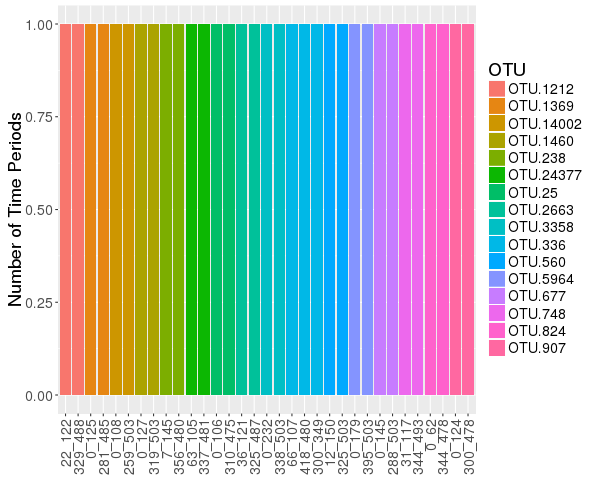

In [185]:
%%R -w 600
TS.sig$ISIE = paste(TS.sig$Interval.start, TS.sig$Interval.end, sep = '_')
MResp = filter(TS.sig, OTU %in% Mult_resp$OTU) %>% group_by(OTU)

MResp$ISIE = factor(MResp$ISIE, levels = MResp$ISIE[order(MResp$OTU)])


ggplot(MResp, aes(x = ISIE, group = OTU)) + geom_bar(aes(fill = OTU))  + 
        theme(text = element_text(size=18),
        axis.title.y = element_text(vjust=1),
        axis.text.x = element_text(angle=90, vjust=0.5, hjust=1)) + xlab(NULL) + 
        ylab('Number of Time Periods')

In [190]:
%%R
head(DF2)
DF.sum = DF2 %>% group_by(C, time, class) %>% summarise(meanab = mean(abundance), sdab = sd(abundance))

In [191]:
%%R
head(DF.sum)

Source: local data frame [6 x 5]
Groups: C, time [3]

      C  time  class   meanab      sdab
  (chr) (dbl) (fctr)    (dbl)     (dbl)
1 OTU.1     0      N 7.441876 0.6329708
2 OTU.1     0      P 8.088478 0.5886967
3 OTU.1    76      N 7.767856 0.5694186
4 OTU.1    76      P 8.611005 0.5993698
5 OTU.1   111      N 7.709216 0.3186873
6 OTU.1   111      P 8.139651 0.3456641


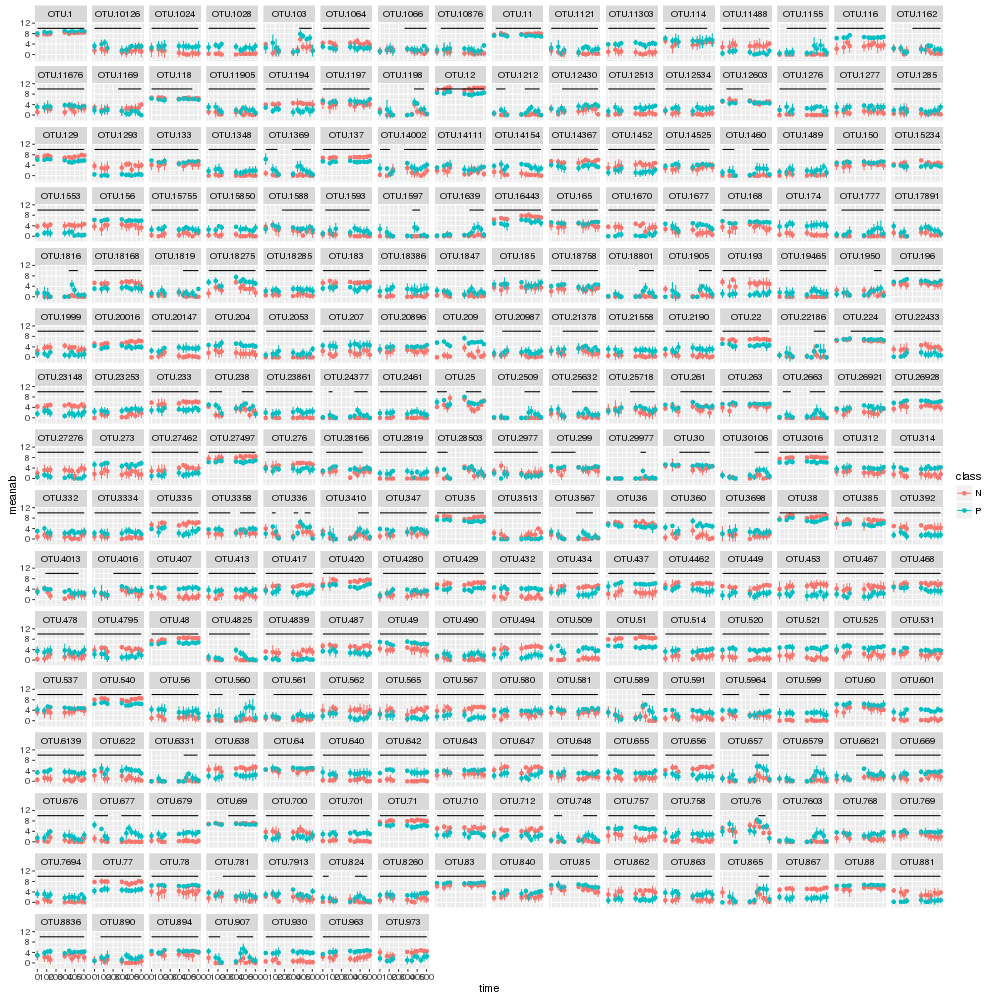

In [192]:
%%R -h 1000 -w 1000
TS.sig$C = TS.sig$OTU

limits = aes(ymax = meanab + sdab, ymin=meanab -sdab, color = class)


ggplot(DF.sum, aes(x = time, y = meanab)) + 
geom_point(aes(color = class)) + 
geom_errorbar(limits, width=0.25)+
geom_segment(data = TS.sig, aes(x = Interval.start, xend = Interval.end, y = 10, yend = 10)) +
facet_wrap(~C)

In [221]:
%%R
head(TS.sig)
Mult_TS = TS.sig %>% group_by(OTU) %>% mutate(TS_num = n())

head(Mult_TS) %>% as.data.frame

                    X Interval.start Interval.end       Area p.value adjPvalues
1 OTU.1348 interval:1              0          503   823.8337       0          0
2  OTU.638 interval:1              0          503 -1413.4817       0          0
3 OTU.1950 interval:1            400          482   132.2536       0          0
4  OTU.963 interval:1              0          503  1151.5664       0          0
5 OTU.1169 interval:1            255          503  -388.9061       0          0
6 OTU.2509 interval:1            326          494   242.5708       0          0
       OTU interval num    ISIE        C TS_num
1 OTU.1348 interval   1   0_503 OTU.1348      1
2  OTU.638 interval   1   0_503  OTU.638      1
3 OTU.1950 interval   1 400_482 OTU.1950      1
4  OTU.963 interval   1   0_503  OTU.963      1
5 OTU.1169 interval   1 255_503 OTU.1169      1
6 OTU.2509 interval   1 326_494 OTU.2509      1


In [223]:
%%R
Mult_TS_sum = Mult_TS %>% group_by(ISIE) %>% mutate(counts = n())

In [224]:
%%R
head(Mult_TS_sum)

Source: local data frame [6 x 13]
Groups: ISIE [4]

                    X Interval.start Interval.end       Area p.value adjPvalues
               (fctr)          (int)        (int)      (dbl)   (dbl)      (dbl)
1 OTU.1348 interval:1              0          503   823.8337       0          0
2  OTU.638 interval:1              0          503 -1413.4817       0          0
3 OTU.1950 interval:1            400          482   132.2536       0          0
4  OTU.963 interval:1              0          503  1151.5664       0          0
5 OTU.1169 interval:1            255          503  -388.9061       0          0
6 OTU.2509 interval:1            326          494   242.5708       0          0
Variables not shown: OTU (chr), interval (chr), num (chr), ISIE (chr), C (chr),
  TS_num (int), counts (int)


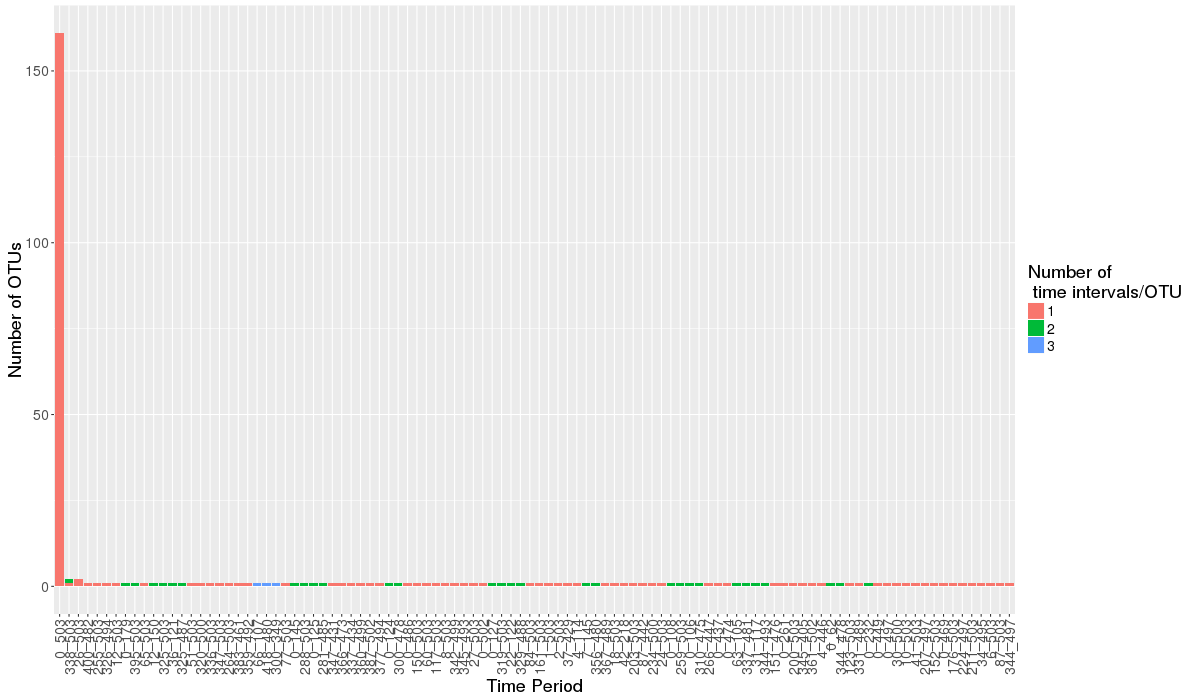

In [232]:
%%R -w 1200 -h 700

Mult_TS$ISIE = factor(Mult_TS$ISIE, levels = Mult_TS$ISIE[order(-Mult_TS_sum$counts)])


ggplot(Mult_TS, aes(x = ISIE)) + geom_bar(aes(fill = as.factor(TS_num))) + #+ facet_wrap(~TS_num)+
        theme(text = element_text(size=18),
        axis.title.y = element_text(vjust=1),
        axis.text.x = element_text(angle=90, vjust=0.5, hjust=1))  + xlab('Time Period')+ 
        scale_fill_discrete(name = 'Number of \n time intervals/OTU') +
        ylab('Number of OTUs') 


In [193]:
%%R
sessionInfo()

R version 3.2.3 (2015-12-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu precise (12.04.5 LTS)

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  tools     stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] doParallel_1.0.10     iterators_1.0.8       metagenomeSeq_1.11.10
 [4] RColorBrewer_1.1-2    glmnet_2.0-3          foreach_1.4.3        
 [7] Matrix_1.2-3          limma_3.22.7          Biobase_2.26.0       
[10] BiocGenerics_0.12.1   biom_0.3.12           scales_0.3.0         
[13] dplyr_0.4.3           plyr_1.8.3            tidyr_0.4.1          
[16] phyloseq_1.10.0 

## Sandbox

In [104]:
%%R
Make_DF = function(TS) {  
    
    d = data.frame(TS$data[, c("abundance","class", "time", "id")])
    d$Sample = rownames(TS$data)


    return(d)
}

In [105]:
%%R
l = list()
for (i in 1:length(feature)) {
    classname = as.vector(feature[i])
    l[[classname]] = Make_DF(TS[[i]])
    
}

In [106]:
%%R
DF = do.call(rbind, l)

In [107]:
%%R
DF$Class_Sample = rownames(DF)

In [108]:
%%R
head(DF)

                        abundance class time             id         Sample
OTU.1348.Nov.NTR.4.2015         0     N  503 Nov.NTR.4.2015 Nov.NTR.4.2015
OTU.1348.S.NTR.2                0     N   76        S.NTR.2        S.NTR.2
OTU.1348.June15.NTH.2           0     N  342   June15.NTH.2   June15.NTH.2
OTU.1348.Oct.NTR.1.2015         0     N  474 Oct.NTR.1.2015 Oct.NTR.1.2015
OTU.1348.July.NTR1              0     N    0      July.NTR1      July.NTR1
OTU.1348.July.NTR4              0     N    0      July.NTR4      July.NTR4
                                   Class_Sample
OTU.1348.Nov.NTR.4.2015 OTU.1348.Nov.NTR.4.2015
OTU.1348.S.NTR.2               OTU.1348.S.NTR.2
OTU.1348.June15.NTH.2     OTU.1348.June15.NTH.2
OTU.1348.Oct.NTR.1.2015 OTU.1348.Oct.NTR.1.2015
OTU.1348.July.NTR1           OTU.1348.July.NTR1
OTU.1348.July.NTR4           OTU.1348.July.NTR4


In [109]:
%%R
unique(DF$time)

 [1] 503  76 342 474   0 111 399 139 440 294 371


In [110]:
%%R
DF2 = separate(DF, Class_Sample, c('OTU', "num", "MY", "Treat", 'Rep'), sep = '\\.' )
DF2$C = paste(DF2$OTU, DF2$num, sep = '.')
DF2$Full.sample = paste(DF2$MY, DF2$Treat, DF2$Rep, sep = '.')
head(DF2)


                        abundance class time             id         Sample OTU
OTU.1348.Nov.NTR.4.2015         0     N  503 Nov.NTR.4.2015 Nov.NTR.4.2015 OTU
OTU.1348.S.NTR.2                0     N   76        S.NTR.2        S.NTR.2 OTU
OTU.1348.June15.NTH.2           0     N  342   June15.NTH.2   June15.NTH.2 OTU
OTU.1348.Oct.NTR.1.2015         0     N  474 Oct.NTR.1.2015 Oct.NTR.1.2015 OTU
OTU.1348.July.NTR1              0     N    0      July.NTR1      July.NTR1 OTU
OTU.1348.July.NTR4              0     N    0      July.NTR4      July.NTR4 OTU
                         num     MY Treat  Rep        C  Full.sample
OTU.1348.Nov.NTR.4.2015 1348    Nov   NTR    4 OTU.1348    Nov.NTR.4
OTU.1348.S.NTR.2        1348      S   NTR    2 OTU.1348      S.NTR.2
OTU.1348.June15.NTH.2   1348 June15   NTH    2 OTU.1348 June15.NTH.2
OTU.1348.Oct.NTR.1.2015 1348    Oct   NTR    1 OTU.1348    Oct.NTR.1
OTU.1348.July.NTR1      1348   July  NTR1 <NA> OTU.1348 July.NTR1.NA
OTU.1348.July.NTR4      1348   Ju

In [111]:
%%R
length(unique(DF2$Rep))

[1] 5


In [112]:
%%R
Make_DF2 = function(TS) {  
    
    d = data.frame(TS$timeIntervals)


    return(d)
}

In [113]:
%%R
l.pval = list()
for (i in 1:length(feature)) {
    classname = as.character(feature[i])
    l.pval[[classname]] = Make_DF2(TS[[i]])
    
}

In [114]:
%%R
l.pval2 = list()


for (i in 1:length(l.pval)) {
        if (length(l.pval[[i]]) == 1) {
        l.pval2[[i]] = l.pval[[i]]
        l.pval2[[i]]$Interval.start = NA
        l.pval2[[i]]$Interval.end = NA
        l.pval2[[i]]$Area = NA
        l.pval2[[i]]$p.value = NA
        l.pval2[[i]]$TS.timeIntervals = NULL
    } else {
            l.pval2[[i]] = l.pval[[i]]
        } 
    
}

In [115]:
%%R

l.pval3 = list()
for (i in 1:length(feature)) {
    classname = as.character(feature[i])
    l.pval3[[classname]] = l.pval2[[i]]
    
}

In [116]:
%%R
DF3 = do.call(rbind, l.pval3)

In [117]:
%%R
DF3$C = rownames(DF3)
head(DF3)


           Interval.start Interval.end         Area p.value          C
OTU.1348                0          503   823.833690   0.000   OTU.1348
OTU.99                 NA           NA           NA      NA     OTU.99
OTU.638                 0          503 -1413.481698   0.000    OTU.638
OTU.1950.1            400          482   132.253649   0.000 OTU.1950.1
OTU.1950.2              0            4    -5.828632   0.012 OTU.1950.2
OTU.1950.3            287          293    -8.309992   0.003 OTU.1950.3


In [118]:
%%R
head(DF2)
df.total = left_join(DF2, DF3)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Joining by: "C"

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [119]:
%%R
head(df.total)

  abundance class time             id         Sample OTU  num     MY Treat  Rep
1         0     N  503 Nov.NTR.4.2015 Nov.NTR.4.2015 OTU 1348    Nov   NTR    4
2         0     N   76        S.NTR.2        S.NTR.2 OTU 1348      S   NTR    2
3         0     N  342   June15.NTH.2   June15.NTH.2 OTU 1348 June15   NTH    2
4         0     N  474 Oct.NTR.1.2015 Oct.NTR.1.2015 OTU 1348    Oct   NTR    1
5         0     N    0      July.NTR1      July.NTR1 OTU 1348   July  NTR1 <NA>
6         0     N    0      July.NTR4      July.NTR4 OTU 1348   July  NTR4 <NA>
         C  Full.sample Interval.start Interval.end     Area p.value
1 OTU.1348    Nov.NTR.4              0          503 823.8337       0
2 OTU.1348      S.NTR.2              0          503 823.8337       0
3 OTU.1348 June15.NTH.2              0          503 823.8337       0
4 OTU.1348    Oct.NTR.1              0          503 823.8337       0
5 OTU.1348 July.NTR1.NA              0          503 823.8337       0
6 OTU.1348 July.NTR4.NA   

In [120]:
%%R
length(unique(df.total$C))

[1] 284


In [121]:
%%R
Make_DF3 = function(TS) {  
    
    d = data.frame(TS$fit[, c("fit","se", "timePoints")])
    d$Sample = rownames(TS$fit)


    return(d)
}

In [122]:
%%R

l2 = list()
for (i in 1:length(feature)) {
    classname = as.vector(feature[i])
    l2[[classname]] = Make_DF3(TS[[i]])
    
}

In [123]:
%%R
fit = do.call(rbind, l2)

In [124]:
%%R
head(fit)

                fit        se timePoints Sample
OTU.1348.1 1.845508 0.3691230          0      1
OTU.1348.2 1.844468 0.3677421          1      2
OTU.1348.3 1.843428 0.3663674          2      3
OTU.1348.4 1.842387 0.3649990          3      4
OTU.1348.5 1.841347 0.3636369          4      5
OTU.1348.6 1.840306 0.3622813          5      6


In [125]:
%%R
require(tidyr)
fit$C = rownames(fit)
fit$time = fit$timePoints
fit$timePoints = NULL

In [126]:
%%R
fit2 = fit %>% separate(C, c("OTU", 'num', 'extra'), sep = '\\.')
fit2$C = paste(fit2$OTU, fit2$num, sep ='.')
fit2$OTU = NULL
fit2$num = NULL
fit2$extra = NULL
head(fit2)

                fit        se Sample time        C
OTU.1348.1 1.845508 0.3691230      1    0 OTU.1348
OTU.1348.2 1.844468 0.3677421      2    1 OTU.1348
OTU.1348.3 1.843428 0.3663674      3    2 OTU.1348
OTU.1348.4 1.842387 0.3649990      4    3 OTU.1348
OTU.1348.5 1.841347 0.3636369      5    4 OTU.1348
OTU.1348.6 1.840306 0.3622813      6    5 OTU.1348


In [127]:
%%R
df.all = left_join(df.total, fit2, by = c('time', 'C'))

In [128]:
%%R
head(df.all)

  abundance class time             id       Sample.x OTU  num     MY Treat  Rep
1         0     N  503 Nov.NTR.4.2015 Nov.NTR.4.2015 OTU 1348    Nov   NTR    4
2         0     N   76        S.NTR.2        S.NTR.2 OTU 1348      S   NTR    2
3         0     N  342   June15.NTH.2   June15.NTH.2 OTU 1348 June15   NTH    2
4         0     N  474 Oct.NTR.1.2015 Oct.NTR.1.2015 OTU 1348    Oct   NTR    1
5         0     N    0      July.NTR1      July.NTR1 OTU 1348   July  NTR1 <NA>
6         0     N    0      July.NTR4      July.NTR4 OTU 1348   July  NTR4 <NA>
         C  Full.sample Interval.start Interval.end     Area p.value      fit
1 OTU.1348    Nov.NTR.4              0          503 823.8337       0 1.562589
2 OTU.1348      S.NTR.2              0          503 823.8337       0 1.766164
3 OTU.1348 June15.NTH.2              0          503 823.8337       0 1.553549
4 OTU.1348    Oct.NTR.1              0          503 823.8337       0 1.556869
5 OTU.1348 July.NTR1.NA              0          50

In [129]:
%%R
unique(df.all$Interval.end)

 [1] 503  NA 494 462  86 402 486 412 316 499 493 502 388  38 435 218 442 500 437
[20] 474 476 446 297 489 449 497 465 332 469 495


In [130]:
%%R
df.sig = filter(df.all, p.value <=0.01)

In [131]:
%%R
write.csv(df.sig, file = "data/Till_TS.csv",row.names=FALSE)

In [132]:
%%R
df.sig = read.csv('data/Till_TS.csv')

In [133]:
%%R
length(unique(df.sig$C))

[1] 231


In [134]:
%%R
head(df.sig)

  abundance class time             id       Sample.x OTU  num     MY Treat Rep
1         0     N  503 Nov.NTR.4.2015 Nov.NTR.4.2015 OTU 1348    Nov   NTR   4
2         0     N   76        S.NTR.2        S.NTR.2 OTU 1348      S   NTR   2
3         0     N  342   June15.NTH.2   June15.NTH.2 OTU 1348 June15   NTH   2
4         0     N  474 Oct.NTR.1.2015 Oct.NTR.1.2015 OTU 1348    Oct   NTR   1
5         0     N    0      July.NTR1      July.NTR1 OTU 1348   July  NTR1  NA
6         0     N    0      July.NTR4      July.NTR4 OTU 1348   July  NTR4  NA
         C  Full.sample Interval.start Interval.end     Area p.value      fit
1 OTU.1348    Nov.NTR.4              0          503 823.8337       0 1.562589
2 OTU.1348      S.NTR.2              0          503 823.8337       0 1.766164
3 OTU.1348 June15.NTH.2              0          503 823.8337       0 1.553549
4 OTU.1348    Oct.NTR.1              0          503 823.8337       0 1.556869
5 OTU.1348 July.NTR1.NA              0          503 823.8

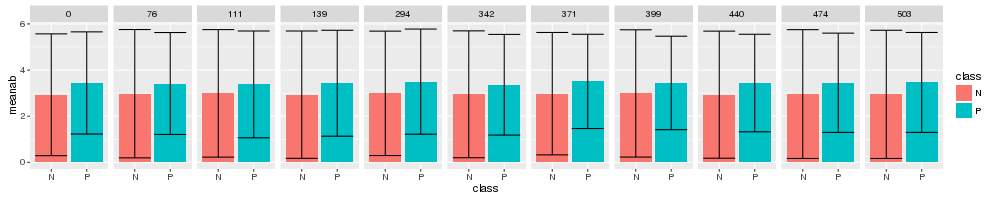

In [135]:
%%R -w 1000 -h 200
df.time = df.sig %>% group_by(class, time) %>% summarise(meanab = mean(abundance), sdab = sd(abundance))

p = ggplot(df.time, aes(x = class, y = meanab))  + geom_bar(stat = 'identity', aes(fill = class)) +
                    facet_wrap(~time, nrow = 1) + geom_errorbar(aes(ymin = meanab - sdab, ymax = meanab + sdab))
                                                            theme(text = element_text(size=18),
                                                            axis.title.y = element_text(vjust=1),
                                                            axis.text.x = element_text(angle=90, vjust=0.5, hjust=1))
p

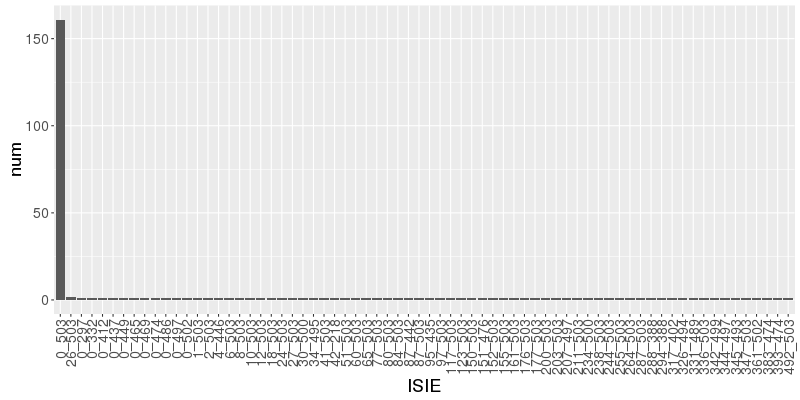

In [136]:
%%R -w 800 -h 400
df.interval = df.sig %>% group_by(C) %>% summarise(IS = mean(Interval.start), IE = mean(Interval.end)) %>%
                group_by(IS, IE) %>% summarise(num = n())

df.interval$ISIE = paste(df.interval$IS, df.interval$IE, sep = '_')

df.interval$ISIE = factor(df.interval$ISIE, levels = df.interval$ISIE[order(-df.interval$num)])


p = ggplot(df.interval, aes(x = ISIE, y = num))  + geom_bar(stat = 'identity') +
                                                            theme(text = element_text(size=18),
                                                            axis.title.y = element_text(vjust=1),
                                                            axis.text.x = element_text(angle=90, vjust=0.5, hjust=1))
p


In [137]:
%%R
head(df.sig)

  abundance class time             id       Sample.x OTU  num     MY Treat Rep
1         0     N  503 Nov.NTR.4.2015 Nov.NTR.4.2015 OTU 1348    Nov   NTR   4
2         0     N   76        S.NTR.2        S.NTR.2 OTU 1348      S   NTR   2
3         0     N  342   June15.NTH.2   June15.NTH.2 OTU 1348 June15   NTH   2
4         0     N  474 Oct.NTR.1.2015 Oct.NTR.1.2015 OTU 1348    Oct   NTR   1
5         0     N    0      July.NTR1      July.NTR1 OTU 1348   July  NTR1  NA
6         0     N    0      July.NTR4      July.NTR4 OTU 1348   July  NTR4  NA
         C  Full.sample Interval.start Interval.end     Area p.value      fit
1 OTU.1348    Nov.NTR.4              0          503 823.8337       0 1.562589
2 OTU.1348      S.NTR.2              0          503 823.8337       0 1.766164
3 OTU.1348 June15.NTH.2              0          503 823.8337       0 1.553549
4 OTU.1348    Oct.NTR.1              0          503 823.8337       0 1.556869
5 OTU.1348 July.NTR1.NA              0          503 823.8

In [138]:
%%R
length(df.sig$C)

[1] 40425


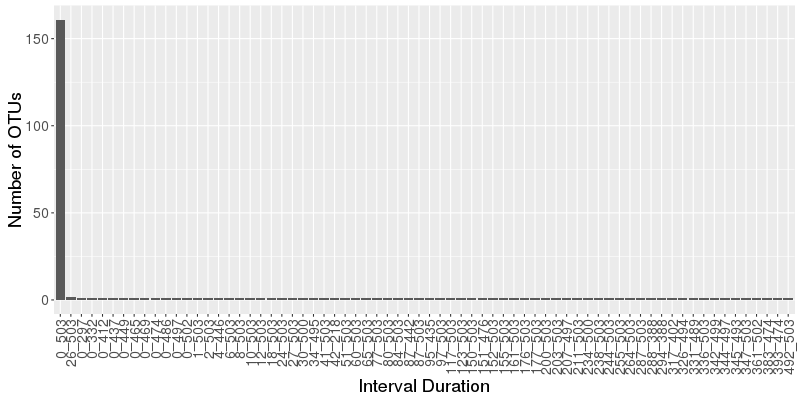

In [139]:
%%R -w 800 -h 400
df.interval = df.sig %>% group_by(C) %>% summarise(IS = mean(Interval.start), IE = mean(Interval.end)) %>%
        group_by(IS, IE) %>% summarise(num = n()) %>% as.data.frame

df.interval$ISIE = paste(df.interval$IS, df.interval$IE, sep = '_')
df.interval$ISIE <- factor(df.interval$ISIE, levels =df.interval$ISIE[order(-df.interval$num)])

ggplot(df.interval,aes(x = ISIE, y = num)) + geom_bar(stat = 'identity') + theme(text = element_text(size=18),
        axis.title.y = element_text(vjust=1),
        axis.text.x = element_text(angle=90, vjust=0.5, hjust=1)) + xlab('Interval Duration') + ylab('Number of OTUs')

In [140]:
%%R
df.sig %>% group_by(C) %>% summarise(IS = mean(Interval.start), IE = mean(Interval.end))

Source: local data frame [231 x 3]

           C    IS    IE
      (fctr) (dbl) (dbl)
1      OTU.1     0   503
2  OTU.10126     0   503
3   OTU.1024     0   503
4   OTU.1028     0   503
5   OTU.1064     0   503
6   OTU.1066   264   503
7  OTU.10876    41   503
8     OTU.11    18   503
9   OTU.1121     0   503
10 OTU.11303     0   503
..       ...   ...   ...


In [141]:
%%R
print(unique(df.sig$time))
print(unique(df.sig$Interval.start))
print(unique(df.sig$Interval.end))

 [1] 503  76 342 474   0 111 399 139 440 294 371
 [1]   0 255 326  12  65  26  51 336 347 264 317  77 150  60 117 287   8 342 345
[20]  27 288 238 492  84 161   1   2  95 294  18  42 203  87 234  24 155 151 200
[39] 361   4 177  97 123 331 383 393  80  30  10 244  41 207 152 176 211  34   6
[58] 344
 [1] 503 494 402 486 412 499 493 502 388 435 218 442 500 437 474 476 446 297 489
[20] 449 497 465 332 469 495


%%R


df.sig$T[df.sig$time == 0] = '2014-7-10'
df.sig$T[df.sig$time == 2] = '2014-9-24'
df.sig$T[df.sig$time == 3] = '2014-10-29'
df.sig$T[df.sig$time == 4] = '2014-11-26'
df.sig$T[df.sig$time == 9] = '2015-4-30'
df.sig$T[df.sig$time == 11] = '2015-6-17'
df.sig$T[df.sig$time == 12] = '2015-7-16'
df.sig$T[df.sig$time == 13] = '2015-8-13'
df.sig$T[df.sig$time == 14] = '2015-9-23'
df.sig$T[df.sig$time == 15] = '2015-10-27'
df.sig$T[df.sig$time == 16] = '2015-11-25'

df.sig$T = as.POSIXct(strptime(df.sig$T, format = "%Y-%m-%d"))


df.sig$Interval.start[df.sig$Interval.start == 0] = '2014-7-10'
df.sig$Interval.start[df.sig$Interval.start == 2] = '2014-9-24'
df.sig$Interval.start[df.sig$Interval.start == 3] = '2014-10-29'
df.sig$Interval.start[df.sig$Interval.start == 4] = '2014-11-26'
df.sig$Interval.start[df.sig$Interval.start == 9] = '2015-4-30'
df.sig$Interval.start[df.sig$Interval.start == 11] = '2015-6-17'
df.sig$Interval.start[df.sig$Interval.start == 12] = '2015-7-16'
df.sig$Interval.start[df.sig$Interval.start == 13] = '2015-8-13'
df.sig$Interval.start[df.sig$Interval.start== 14] = '2015-9-23'
df.sig$Interval.start[df.sig$Interval.start == 15] = '2015-10-27'
df.sig$Interval.start[df.sig$Interval.start == 16] = '2015-11-25'

df.sig$Interval.start = as.POSIXct(strptime(df.sig$Interval.start, format = "%Y-%m-%d"))

df.sig$Interval.end[df.sig$Interval.end == 0] = '2014-7-10'
df.sig$Interval.end[df.sig$Interval.end == 2] = '2014-9-24'
df.sig$Interval.end[df.sig$Interval.end == 3] = '2014-10-29'
df.sig$Interval.end[df.sig$Interval.end == 4] = '2014-11-26'
df.sig$Interval.end[df.sig$Interval.end == 9] = '2015-4-30'
df.sig$Interval.end[df.sig$Interval.end == 11] = '2015-6-17'
df.sig$Interval.end[df.sig$Interval.end == 12] = '2015-7-16'
df.sig$Interval.end[df.sig$Interval.end == 13] = '2015-8-13'
 df.sig$Interval.end[df.sig$Interval.end == 14] = '2015-9-23'
df.sig$Interval.end[df.sig$Interval.end == 15] = '2015-10-27'
df.sig$Interval.end[df.sig$Interval.end == 16] = '2015-11-25'
# 
df.sig$Interval.end = as.POSIXct(strptime(df.sig$Interval.end, format = "%Y-%m-%d"))


head(df.sig)

In [142]:
%%R
length(unique(df.sig$C))

[1] 231


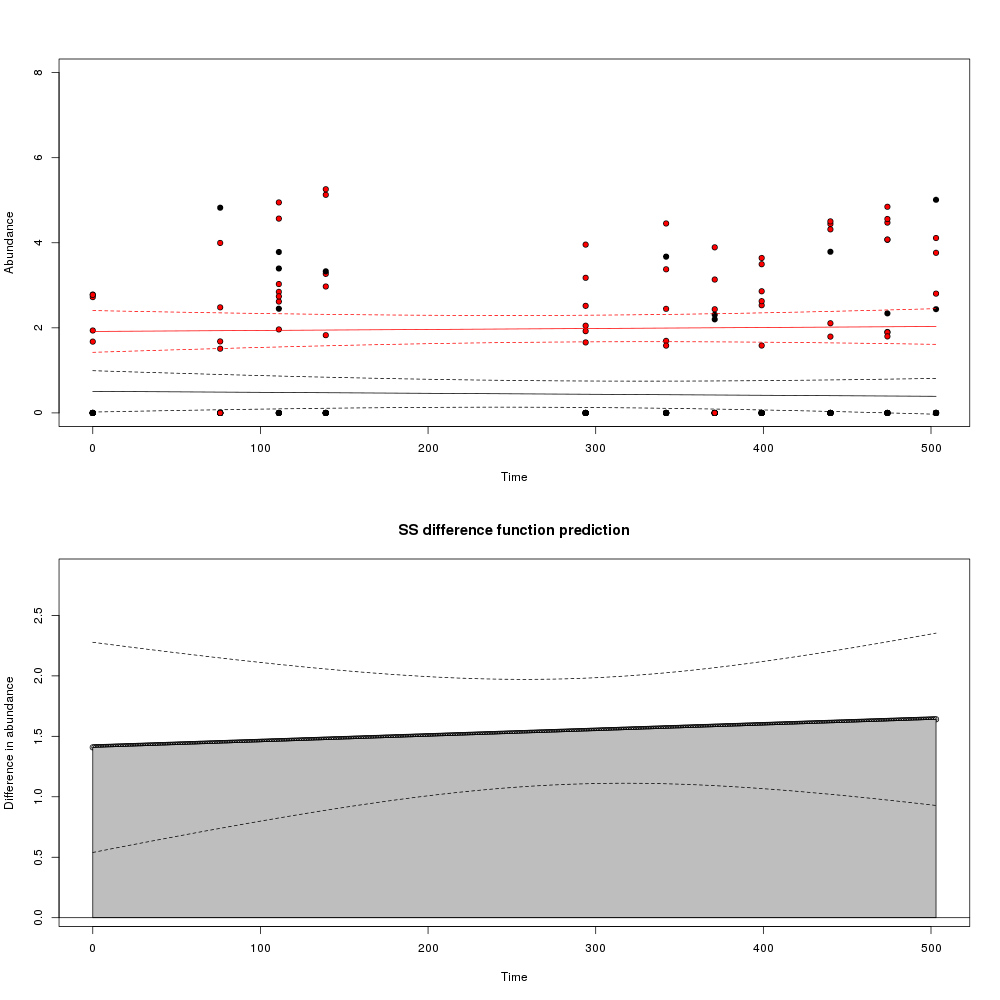

In [143]:
%%R -h 1000 -w 1000
Phy = TS[[60]]
par(mfrow = c(2, 1))
plotClassTimeSeries(Phy, pch = 21, bg = Phy$data$class, ylim = c(0,8))
plotTimeSeries(Phy)

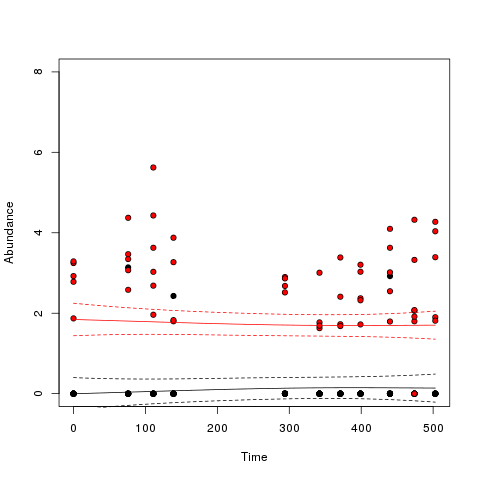

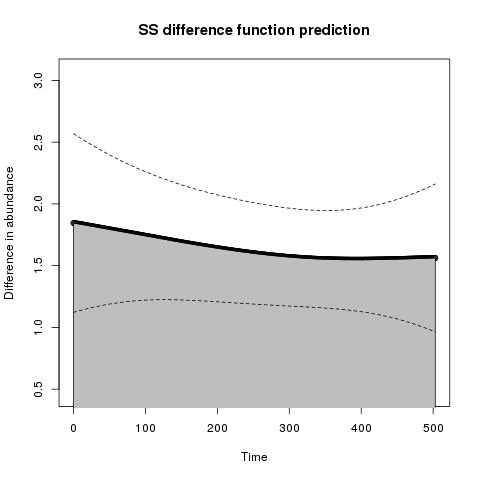

In [144]:
%%R
plotClassTimeSeries(TS[[1]], pch = 21, bg = Phy$data$class, ylim = c(0,8))
plotTimeSeries(TS[[1]])

In [145]:
%%R
plotClassTimeSeries.df <-function(df, formula, v, xlab="Time",ylab="Abundance",color0="black",
                            color1="red",include=c("1","class", "time:class"),...){
    if(missing(formula)){
        mod = gss::ssanova(abundance ~ time * class, data=df)
    } else{
        mod = gss::ssanova(formula,data=df)
    }
    
    timePoints = seq(min(df$time),max(df$time),by=1)
    group0 = data.frame(time=timePoints,class=levels(df$class)[1])
    group1 = data.frame(time=timePoints,class=levels(df$class)[2])
    pred0  = predict(mod, newdata=group0,include=include, se=TRUE)
    pred1  = predict(mod, newdata=group1,include=include, se=TRUE)
    
    
    plot(x=df$time,y=df$abundance,xlab=xlab,ylab=ylab,...)
    lines(x=group0$time,y=pred0$fit,col=color0)
    lines(x=group0$time,y=pred0$fit+(1.96*pred0$se),lty=2,col=color0)
    lines(x=group0$time,y=pred0$fit-(1.96*pred0$se),lty=2,col=color0)

    lines(x=group1$time,y=pred1$fit,col=color1)
    lines(x=group1$time,y=pred1$fit+(1.96*pred1$se),lty=2,col=color1)
    lines(x=group1$time,y=pred1$fit-(1.96*pred1$se),lty=2,col=color1)
    
    title(main = v)
    
   #text(bquote(paste(.(unique(df$p.value)))))
}

In [146]:
%%R
head(df.sig)

  abundance class time             id       Sample.x OTU  num     MY Treat Rep
1         0     N  503 Nov.NTR.4.2015 Nov.NTR.4.2015 OTU 1348    Nov   NTR   4
2         0     N   76        S.NTR.2        S.NTR.2 OTU 1348      S   NTR   2
3         0     N  342   June15.NTH.2   June15.NTH.2 OTU 1348 June15   NTH   2
4         0     N  474 Oct.NTR.1.2015 Oct.NTR.1.2015 OTU 1348    Oct   NTR   1
5         0     N    0      July.NTR1      July.NTR1 OTU 1348   July  NTR1  NA
6         0     N    0      July.NTR4      July.NTR4 OTU 1348   July  NTR4  NA
         C  Full.sample Interval.start Interval.end     Area p.value      fit
1 OTU.1348    Nov.NTR.4              0          503 823.8337       0 1.562589
2 OTU.1348      S.NTR.2              0          503 823.8337       0 1.766164
3 OTU.1348 June15.NTH.2              0          503 823.8337       0 1.553549
4 OTU.1348    Oct.NTR.1              0          503 823.8337       0 1.556869
5 OTU.1348 July.NTR1.NA              0          503 823.8

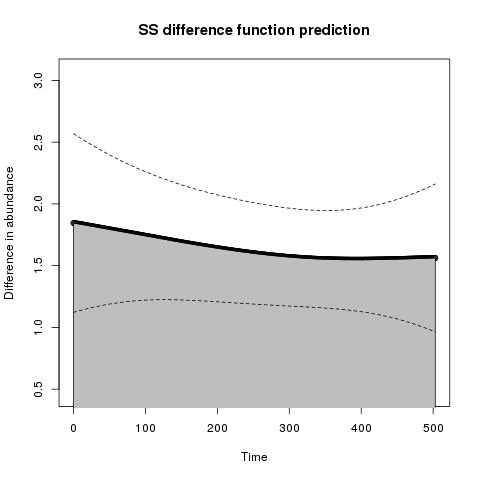

In [147]:
%%R
plotTimeSeries(TS[[1]])

In [148]:
%%R
plotTimeSeries.df <-function(df,C=0,xlab="Time",ylab="Difference in abundance",main="SS difference function prediction",...){
    
    fit = df$fit
    se  = df$se
    timePoints = res$fit$timePoints
    confInt95 = 1.96
    sigDiff = res$timeIntervals

    minValue=min(fit-(confInt95*se))-.5
    maxValue=max(fit+(confInt95*se))+.5

    plot(x=timePoints, y=fit, ylim=c(minValue, maxValue), xlab=xlab, ylab=ylab, main=main, ...)

    for (i in 1:nrow(sigDiff)){
        begin=sigDiff[i,1]
        end=sigDiff[i,2]
        indBegin=which(timePoints==begin)
        indEnd=which(timePoints==end)
        x=timePoints[indBegin:indEnd]
        y=fit[indBegin:indEnd]
        xx=c(x, rev(x))
        yy=c(y, rep(0, length(y)))
        polygon(x=xx, yy, col="grey")
    }
    lines(x=timePoints, y=fit, pch="")
    lines(x=timePoints, y=fit+(confInt95*se), pch="", lty=2)
    lines(x=timePoints, y=fit-(confInt95*se), pch="", lty=2)
    abline(h=C)
}

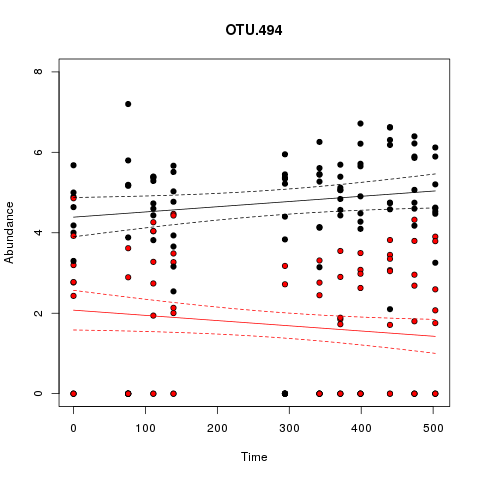

In [149]:
%%R
dftest = filter(df.sig, C == "OTU.494")
plotClassTimeSeries.df(dftest, pch = 21, v= "OTU.494",  bg = dftest$class, ylim = c(0,
8))


In [150]:
%%R
head(pred0)


Error in head(pred0) : 
  error in evaluating the argument 'x' in selecting a method for function 'head': Error: object 'pred0' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 1: Too many values at 18460 locations: 1, 4, 8, 9, 13, 15, 17, 18, 22, 24, 26, 28, 29, 32, 35, 38, 43, 45, 47, 48, ... 

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 2: Too few values at 4544 locations: 5, 6, 19, 25, 31, 39, 42, 57, 62, 84, 99, 100, 102, 103, 104, 110, 180, 181, 194, 200, ... 

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in head(pred0) : 
  error in evaluating the argument 'x' in selecting a method for function 'head': Error: object 'pred0' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [151]:
%%R
lc = list()
for (C in clist){
        d = filter(df.sig, C == C)
        lc[[C]] = d
    }

test = head(lc)


Error in withVisible({ : object 'clist' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in withVisible({ : object 'clist' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [152]:
%%R
registerDoParallel(8)

lapply(lc, plotClassTimeSeries.df, .parallel = TRUE)

list()


In [153]:
%%R -h 2000 -w 1200

do.call("grid.arrange", c(plots.l, nrow=length(names(plots.l))))


Error in do.call("grid.arrange", c(plots.l, nrow = length(names(plots.l)))) : 
  error in evaluating the argument 'args' in selecting a method for function 'do.call': Error: object 'plots.l' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in do.call("grid.arrange", c(plots.l, nrow = length(names(plots.l)))) : 
  error in evaluating the argument 'args' in selecting a method for function 'do.call': Error: object 'plots.l' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [154]:
%%R
head(df.sig)

  abundance class time             id       Sample.x OTU  num     MY Treat Rep
1         0     N  503 Nov.NTR.4.2015 Nov.NTR.4.2015 OTU 1348    Nov   NTR   4
2         0     N   76        S.NTR.2        S.NTR.2 OTU 1348      S   NTR   2
3         0     N  342   June15.NTH.2   June15.NTH.2 OTU 1348 June15   NTH   2
4         0     N  474 Oct.NTR.1.2015 Oct.NTR.1.2015 OTU 1348    Oct   NTR   1
5         0     N    0      July.NTR1      July.NTR1 OTU 1348   July  NTR1  NA
6         0     N    0      July.NTR4      July.NTR4 OTU 1348   July  NTR4  NA
         C  Full.sample Interval.start Interval.end     Area p.value      fit
1 OTU.1348    Nov.NTR.4              0          503 823.8337       0 1.562589
2 OTU.1348      S.NTR.2              0          503 823.8337       0 1.766164
3 OTU.1348 June15.NTH.2              0          503 823.8337       0 1.553549
4 OTU.1348    Oct.NTR.1              0          503 823.8337       0 1.556869
5 OTU.1348 July.NTR1.NA              0          503 823.8

In [155]:
%%R
head(df.sig) %>% as.data.frame

  abundance class time             id       Sample.x OTU  num     MY Treat Rep
1         0     N  503 Nov.NTR.4.2015 Nov.NTR.4.2015 OTU 1348    Nov   NTR   4
2         0     N   76        S.NTR.2        S.NTR.2 OTU 1348      S   NTR   2
3         0     N  342   June15.NTH.2   June15.NTH.2 OTU 1348 June15   NTH   2
4         0     N  474 Oct.NTR.1.2015 Oct.NTR.1.2015 OTU 1348    Oct   NTR   1
5         0     N    0      July.NTR1      July.NTR1 OTU 1348   July  NTR1  NA
6         0     N    0      July.NTR4      July.NTR4 OTU 1348   July  NTR4  NA
         C  Full.sample Interval.start Interval.end     Area p.value      fit
1 OTU.1348    Nov.NTR.4              0          503 823.8337       0 1.562589
2 OTU.1348      S.NTR.2              0          503 823.8337       0 1.766164
3 OTU.1348 June15.NTH.2              0          503 823.8337       0 1.553549
4 OTU.1348    Oct.NTR.1              0          503 823.8337       0 1.556869
5 OTU.1348 July.NTR1.NA              0          503 823.8

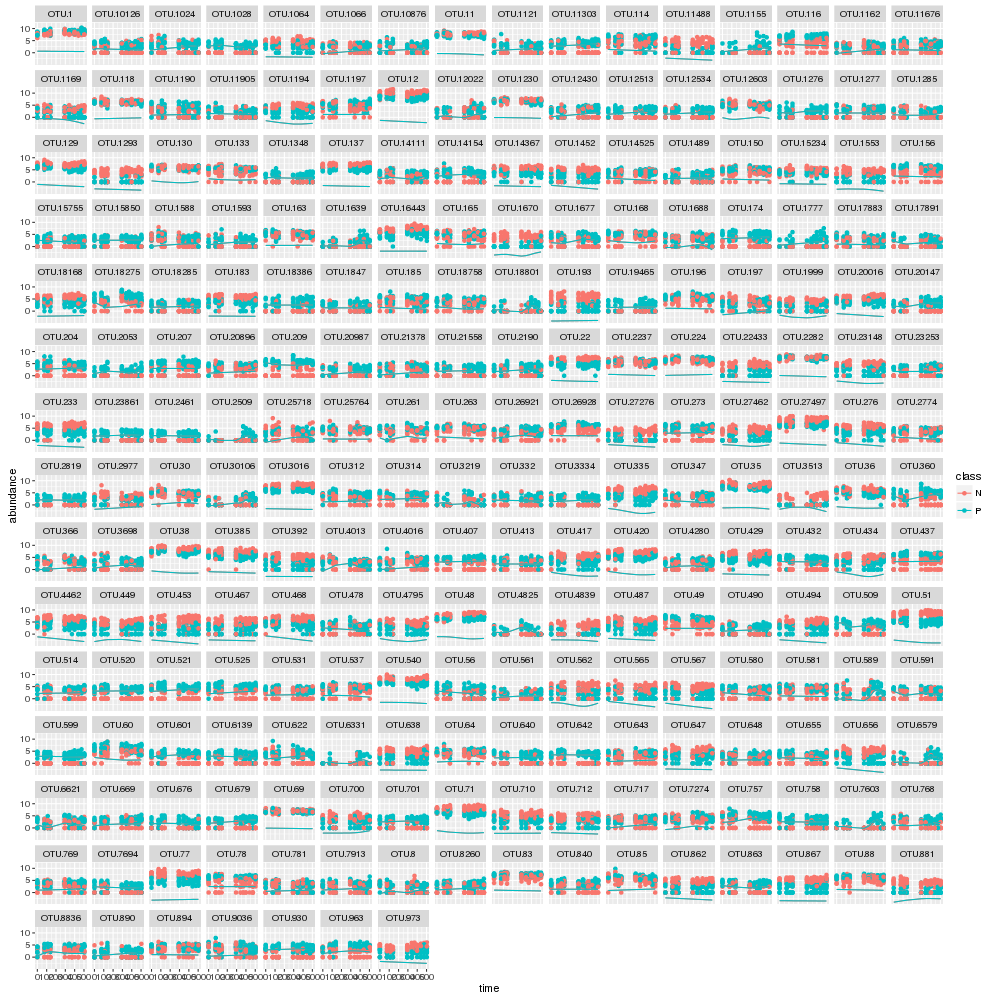

In [156]:
%%R -h 1000 -w 1000
head(df.sig)

ggplot(df.sig, aes(x = time, y = abundance, color = class)) + 
geom_point() + 
geom_line(aes(x = time, y = fit, color = class, group = class)) +
facet_wrap(~C)

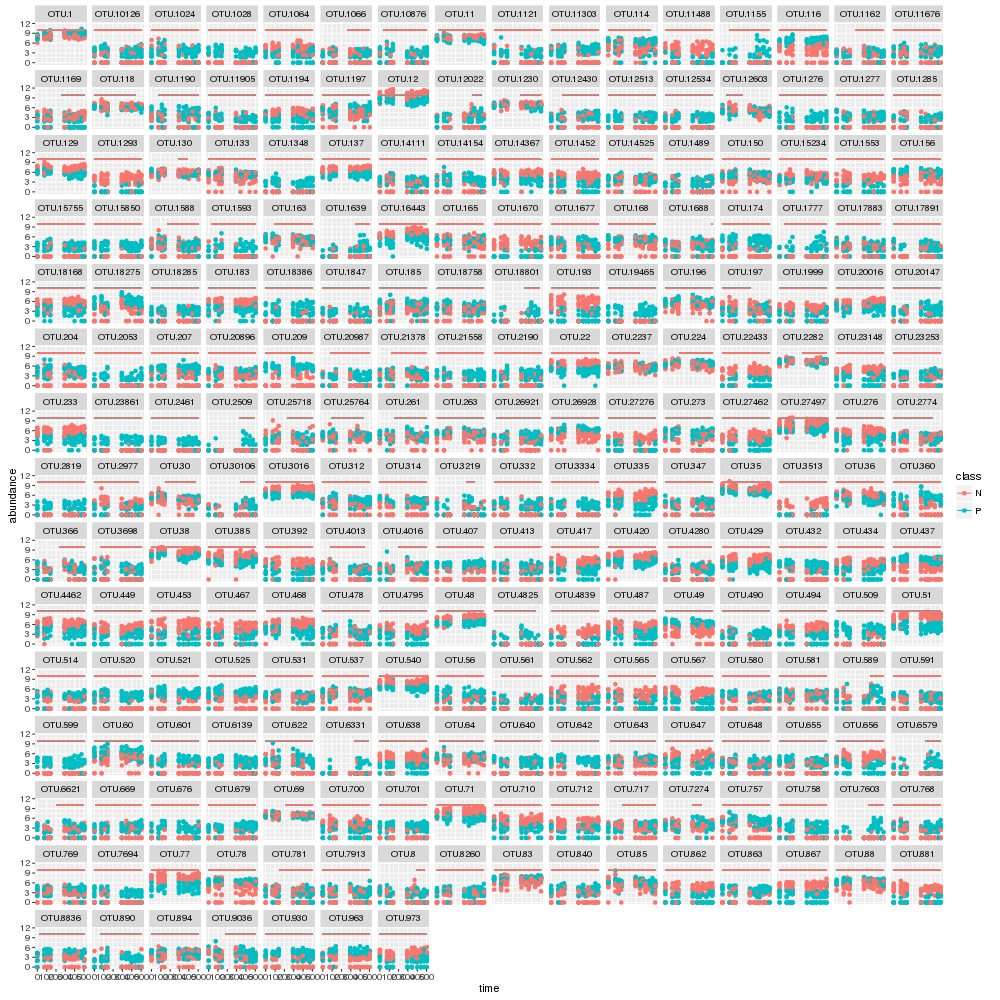

In [157]:
%%R -h 1000 -w 1000
head(df.sig)

ggplot(df.sig, aes(x = time, y = abundance, color = class)) + 
geom_point() + 
geom_segment(aes(x = Interval.start, xend = Interval.end, y = 10, yend = 10)) +
facet_wrap(~C)

In [158]:
%%R
df.sum = df.sig %>% group_by(C, time, class) %>% summarise(meanab = mean(abundance), sdab = sd(abundance))
head(df.sum)

Source: local data frame [6 x 5]
Groups: C, time [3]

       C  time  class   meanab      sdab
  (fctr) (int) (fctr)    (dbl)     (dbl)
1  OTU.1     0      N 7.441876 0.6329708
2  OTU.1     0      P 8.088478 0.5886967
3  OTU.1    76      N 7.767856 0.5694186
4  OTU.1    76      P 8.611005 0.5993698
5  OTU.1   111      N 7.709216 0.3186873
6  OTU.1   111      P 8.139651 0.3456641


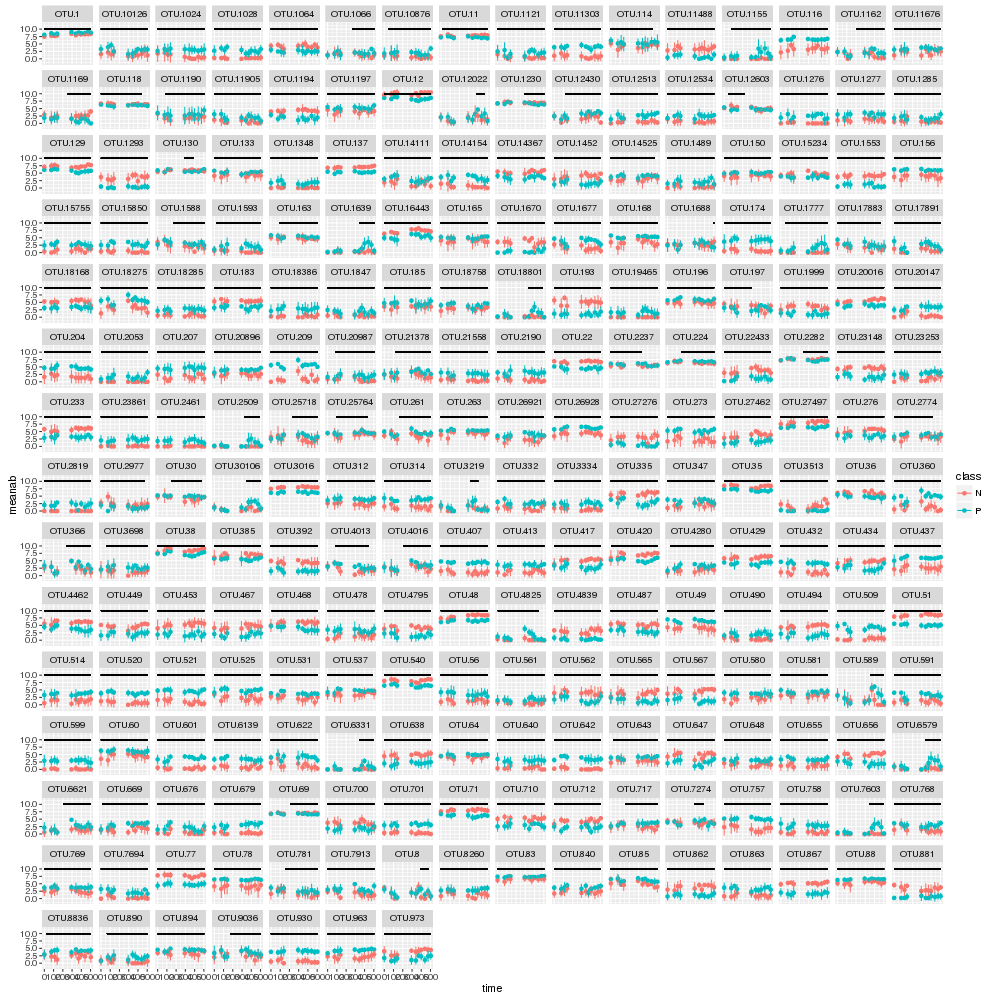

In [159]:
%%R -h 1000 -w 1000
limits = aes(ymax = meanab + sdab, ymin=meanab -sdab, color = class)


ggplot(df.sum, aes(x = time, y = meanab)) + 
geom_point(aes(color = class)) + 
geom_errorbar(limits, width=0.25)+
geom_segment(data = df.sig, aes(x = Interval.start, xend = Interval.end, y = 10, yend = 10)) +
facet_wrap(~C)

In [160]:
%%R
head(df.sig)

  abundance class time             id       Sample.x OTU  num     MY Treat Rep
1         0     N  503 Nov.NTR.4.2015 Nov.NTR.4.2015 OTU 1348    Nov   NTR   4
2         0     N   76        S.NTR.2        S.NTR.2 OTU 1348      S   NTR   2
3         0     N  342   June15.NTH.2   June15.NTH.2 OTU 1348 June15   NTH   2
4         0     N  474 Oct.NTR.1.2015 Oct.NTR.1.2015 OTU 1348    Oct   NTR   1
5         0     N    0      July.NTR1      July.NTR1 OTU 1348   July  NTR1  NA
6         0     N    0      July.NTR4      July.NTR4 OTU 1348   July  NTR4  NA
         C  Full.sample Interval.start Interval.end     Area p.value      fit
1 OTU.1348    Nov.NTR.4              0          503 823.8337       0 1.562589
2 OTU.1348      S.NTR.2              0          503 823.8337       0 1.766164
3 OTU.1348 June15.NTH.2              0          503 823.8337       0 1.553549
4 OTU.1348    Oct.NTR.1              0          503 823.8337       0 1.556869
5 OTU.1348 July.NTR1.NA              0          503 823.8

In [161]:
%%R
sessionInfo()

R version 3.2.3 (2015-12-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu precise (12.04.5 LTS)

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  tools     stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] doParallel_1.0.10     iterators_1.0.8       metagenomeSeq_1.11.10
 [4] RColorBrewer_1.1-2    glmnet_2.0-3          foreach_1.4.3        
 [7] Matrix_1.2-3          limma_3.22.7          Biobase_2.26.0       
[10] BiocGenerics_0.12.1   biom_0.3.12           scales_0.3.0         
[13] dplyr_0.4.3           plyr_1.8.3            tidyr_0.4.1          
[16] phyloseq_1.10.0 